### Imports

In [69]:
import os
import gc
import datetime
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from gensim.utils import simple_preprocess

import torch
from torch import optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

from tqdm.auto import tqdm
from IPython.display import display, clear_output

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [71]:
# drive.mount('/content/drive')

### Downloading the dataset

In [72]:
# !wget http://images.cocodataset.org/zips/train2014.zip

In [73]:
# !wget http://images.cocodataset.org/zips/val2014.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !wget https://nlp.stanford.edu/data/glove.6B.zip

In [74]:
# # !unzip train2014.zip -d /content/drive/MyDrive/paper_replications/show_and_tell/raw_data/coco_train2014
# !unzip val2014.zip -d coco_val2014
# !unzip annotations_trainval2014.zip -d coco_ann2014
# !unzip glove.6B.zip -d glove6b

In [75]:
# !unzip train2014.zip -d data/coco_train2014

In [76]:
# !unzip val2014.zip -d data/coco_val2014

In [77]:
# !rm -rf annotations_trainval2014.zip annotations_trainval2014.zip glove.6B.zip val2014.zip

### Loading Data

In [78]:
# def parse_coco_image_caption(annfile,images_path,samples=1000):
#     image_caption_dict = {}
#     with open(annfile,'r') as file:
#         images = json.load(file)['images']
#     with open(annfile,'r') as file:
#         captions = json.load(file)['annotations']

#     for image_dict in images:
#         image_id = image_dict['id']
#         image = os.path.join(images_path,image_dict['file_name'])
#         if os.path.exists(image):
#             image_caption_dict[image_id] = [image]
#         if len(image_caption_dict)==samples:
#             break
#     captions_in = 0
#     for caption_dict in captions:
#         image_id = caption_dict['image_id']
#         caption = caption_dict['caption']
#         if image_caption_dict.get(image_id,False):
#             if len(image_caption_dict.get(image_id))<=1:
#                 image_caption_dict[image_id].append(caption)
#                 captions_in+=1
#         if captions_in>=samples:
#             break
#     return image_caption_dict

# annfile = 'data/coco_ann2014/annotations/captions_train2014.json'
# images_path = 'data/coco_train2014/train2014'
# samples = 1000
# image_caption_dict = parse_coco_image_caption(annfile,images_path,samples=samples)
# df = pd.DataFrame(image_caption_dict.values(),columns=['image_path','caption'])
# df.head()
# df.to_csv(f'coco_2014_1pair_size{samples}.csv',index=None)

In [79]:
df = pd.read_csv('coco_2014_1pair_size1000.csv')
df.head()

,image_path,caption
0,data/coco_train2014/train2014/COCO_train2014_0...,A restaurant has modern wooden tables and chairs.
1,data/coco_train2014/train2014/COCO_train2014_0...,A man preparing desserts in a kitchen covered ...
2,data/coco_train2014/train2014/COCO_train2014_0...,a big red telephone booth that a man is standi...
3,data/coco_train2014/train2014/COCO_train2014_0...,A child and woman are cooking in the kitchen.
4,data/coco_train2014/train2014/COCO_train2014_0...,A black and white image of a man in a suit wea...


A bathroom features white, bowl sinks and a bathtub.


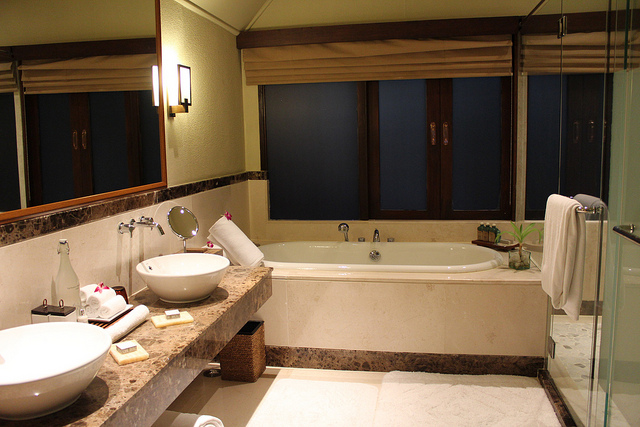

In [80]:
id = 45
img_path = df.iloc[id].image_path
caption = df.iloc[id].caption
print(caption)
Image.open(img_path)

A bus and a few other vehicles that appear to be traveling down the road.


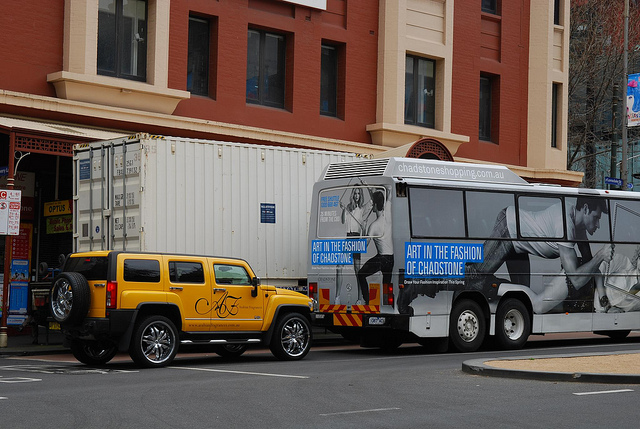

In [81]:
id = 60
img_path = df.iloc[id].image_path
caption = df.iloc[id].caption
print(caption)
Image.open(img_path)

### Custom Dataset Class & Data Loader

In [82]:
class CocoImageCaption(Dataset):
    def __init__(self,image_paths, captions,word2idx, max_doc_len,transformations = None):
        super(Dataset,self).__init__()
        self.image_paths = image_paths
        self.captions = captions
        self.data_size = len(self.image_paths)
        self.word2idx = word2idx
        self.max_doc_len = max_doc_len
        # Preprocess the captions(lowercasing, tokenization etc)
        # Convert the caption into list of indices of word2vec-> to tensor
        self.captions = [simple_preprocess(doc) for doc in self.captions]
        self.lengths = [len(caption) for caption in self.captions]
        # self.captions = torch.LongTensor([self._text2indices(doc) for doc in self.captions])
        if not transformations:
            self.transformations = transforms.Compose([
                                                        transforms.Resize((224, 224)),  # Resize to a fixed size
                                                        transforms.RandomCrop(224, padding=4),  # Apply random crop
                                                        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the images
                                                        transforms.RandomRotation(15),  # Randomly rotate the images
                                                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                                        transforms.ToTensor(),  # Convert the image to a tensor
                                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
                                                        # transforms.Resize((356, 356)),
                                                        # transforms.RandomCrop((299, 299)),
                                                        # transforms.ToTensor(),
                                                        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                            ])

    def __len__(self):
        return self.data_size
    def __getitem__(self, index):
        return self._getimage(index),self._getcaption_embedding(index)

    # def _getimage(self, index):
    #     image = Image.open(self.image_paths[index]).convert('RGB')
    #     return self.transformations(image)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        image = self.transformations(image)
        caption = self.captions[index]
        caption_indices = [self.word2idx.get('<start>')]+[self.word2idx.get(word, self.word2idx.get('<oov>')) for word in caption]+[self.word2idx.get('<end>')]
        return image, torch.tensor(caption_indices)

    def _getcaption_embedding(self,index):
        return self.captions[index]

    def _text2indices(self,text):
        index_list = [self.word2idx.get(word, self.word2idx.get('<oov>')) for i,word in enumerate(text) if i<self.max_doc_len-2]
        # index_list = index_list+[oov_idx]*(self.max_doc_len-2-len(index_list))
        index_list = [self.word2idx.get('<start>')]+index_list+[self.word2idx.get('<end>')]
        return index_list

In [83]:
word_lists = [simple_preprocess(doc) for doc in df['caption'].tolist()]
unique_words = set()
for doc in word_lists:
    for word in doc:
        unique_words.add(word)

In [84]:
word_to_idx = {}
idx_to_word = {}
for idx,word in enumerate(unique_words):
    word_to_idx[word] = idx
    idx_to_word[idx] = word

oov_idx = len(idx_to_word)
word_to_idx['<oov>'] = oov_idx
idx_to_word[oov_idx] = '<oov>'

start_idx = len(idx_to_word)
word_to_idx['<start>'] = start_idx
idx_to_word[start_idx] = '<start>'

end_idx = len(idx_to_word)
word_to_idx['<end>'] = end_idx
idx_to_word[end_idx] = '<end>'

In [85]:
# glove_path = 'data/glove6b/glove.6B.100d.txt'
# word_to_idx = {}
# idx_to_word = {}
# vectors = []
# with open(glove_path,'r',encoding='utf-8') as f:
#     idx = 0
#     for _,line in enumerate(f):
#         elements = line.split()
#         word= elements[0]
#         if word in unique_words:
#             vector = np.asarray(elements[1:],dtype='float32')
#             word_to_idx[word] = idx
#             vectors.append(vector)
#             idx_to_word[idx] = word
#             idx+=1

In [86]:
# oov_vector = np.array([1e-9]*len(vectors[0]),dtype='float32')
# oov_idx = len(vectors)
# vectors.append(oov_vector)
# word_to_idx['<oov>'] = oov_idx
# idx_to_word[oov_idx] = '<oov>'

# start_vector = np.zeros(len(vectors[0]),dtype='float32')
# start_idx = len(vectors)
# vectors.append(start_vector)
# word_to_idx['<start>'] = start_idx
# idx_to_word[start_idx] = '<start>'

# end_vector = np.zeros(len(vectors[0]),dtype='float32')
# end_idx = len(vectors)
# vectors.append(end_vector)
# word_to_idx['<end>'] = end_idx
# idx_to_word[end_idx] = '<end>'


In [87]:
oov_idx,start_idx,end_idx

(1546, 1547, 1548)

In [88]:
len(idx_to_word),len(word_to_idx)

(1549, 1549)

In [89]:
# @title
# self.vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,ngram_range=(1,3),sublinear_tf=True)
# self.captions_emb = self.vectorizer.fit_transform(self.captions)

In [90]:
max_doc_len = max([len(doc) for doc in df['caption'].tolist()])
max_doc_len

147

In [91]:
max_doc_len = 15

In [92]:
image_paths = df['image_path'].tolist()
captions = df['caption'].tolist()
train_image, test_image, trian_caption, test_caption = train_test_split(image_paths,captions,test_size=0.2,random_state=42)
train_dataset = CocoImageCaption(train_image, trian_caption,word_to_idx,max_doc_len)
test_dataset = CocoImageCaption(test_image, test_caption,word_to_idx,max_doc_len)

In [93]:
len(train_image),len(test_image),len(trian_caption),len(test_caption)

(800, 200, 800, 200)

In [94]:
batch_size = 64
num_workers = 0
device = torch.cuda.is_available()
# dataloader_params = {
#                       'batch_size': batch_size,
#                       'num_workers':num_workers,
#                       'persistent_workers':True,
#                       'pin_memory':device,
#                       'pin_memory_device':'cuda' if device else 'cpu'
#                             }
dataloader_params = {
                      'batch_size': batch_size,
                      'num_workers':num_workers,
                            }

In [95]:
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images,0)
    captions = pad_sequence(captions,batch_first=True,padding_value=word_to_idx['<oov>']) # have changed
    return images, captions

In [96]:
train_dataloader = DataLoader(train_dataset,**dataloader_params,shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,**dataloader_params, collate_fn=collate_fn)

In [97]:
len(train_dataloader),len(test_dataloader)

(13, 4)

### Architecture

#### Based on Seq2Seq Machine Translation

In [98]:
# # Encoder CNN layer: (Decide what kind of architecture?)
#     # Input: Image tensor
#     # Output: Image embedding after passing through CNN except last layer.
#     # Takes image tensor, passes through the CNN layer
#     # Get the embedding from the second last layer.
# class CNNEncoder(nn.Module):
#     def __init__(self,embedding_size,p=0.5):
#         super(CNNEncoder,self).__init__()
#         self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
#         # self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
#         self.model = nn.Sequential(*list(self.model.children())[:-1])
#         for param in self.model.parameters():
#             param.requires_grad = False
#         with torch.no_grad():
#             self.in_features = self.model(torch.randn(1,3,224,224)).shape[1]
#         self.fc = nn.Linear(self.in_features,embedding_size)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p)

#     def forward(self,X):
#         X = self.model(X)
#         X = torch.flatten(X,1)
#         X = self.fc(X)
#         return self.dropout(self.relu(X))

# # Decoder LSTM layer:
#     # Input: Image embeddings from CNN encoder, Caption word2vec indices
#     # Output: One hot vector representing the word.
#     # Captions go through word2vec embedding layer to get word vectors
#     # Image embedding and caption embedding get fed to LSTM
#     # LSTM generates hidden state and feeds dense layer generate to generate the
#     # one hot vector for the word predicted.
# class LSTMDecoder(nn.Module):
#     def __init__(self,word_embeddings,embedding_size, hidden_size,num_layers,p,output_size,train_embedding=False):
#         super(LSTMDecoder,self).__init__()
#         self.Word2VecEmbedding = nn.Embedding.from_pretrained(word_embeddings)
#         self.Word2VecEmbedding.weight.requires_grad = train_embedding
#         self.dropout = nn.Dropout(p)
#         self.lstm = nn.LSTM(embedding_size,hidden_size,num_layers,batch_first=True)
#         self.fc = nn.Linear(hidden_size,output_size)

#     def forward(self,X,hidden=None,cell=None,image=False):
#         # predictions = None
#         if image:
#             output, (hidden, cell) = self.lstm(X)
#         else:
#             X = self.dropout(self.Word2VecEmbedding(X))
#             # X = torch.flatten(X,1)
#             output, (hidden, cell) = self.lstm(X,(hidden,cell))
#         predictions = self.fc(output)
#         predictions = predictions.squeeze(0)
#         return predictions, output, hidden,cell
# # Final Model:
#     # Input:
#     # Output:
#     #
# class NeuralImageCaption(nn.Module):
#     def __init__(self,encoder,decoder,vocab_size,batch_size,caption_len):
#         super(NeuralImageCaption,self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.vocab_size = vocab_size
#         self.batch_size = batch_size
#         self.caption_len = caption_len

#     def forward(self, image, caption,teacher_force_ratio=0.3):
#         # batch_size = caption.shape[0]
#         # caption_len = caption.shape[1]
#         outputs = torch.zeros(self.batch_size,self.caption_len,self.vocab_size).to(device)
#         output = self.encoder(image)
#         _, _, hidden, cell = self.decoder(output,image=True)
#         X = caption[:,0]
#         for word_idx in range(1,self.caption_len):
#             prediction, output, hidden, cell = self.decoder(X,hidden,cell)
#             outputs[:,word_idx] = prediction
#             best_guess = torch.argmax(prediction,dim=1)
#             X = caption[:,word_idx]
#             X = caption[:,word_idx] if torch.rand(1)<teacher_force_ratio else best_guess
#         return outputs

#### 2

In [99]:
# Encoder CNN layer: (Decide what kind of architecture?)
#     Input: Image tensor
#     Output: Image embedding after passing through CNN except last layer.
#     Takes image tensor, passes through the CNN layer
#     Get the embedding from the second last layer.
class CNNEncoder(nn.Module):
    def __init__(self,embedding_size,p=0.5):
        super(CNNEncoder,self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        for param in self.model.parameters():
            param.requires_grad = False
        with torch.no_grad():
            self.in_features = self.model(torch.randn(1,3,224,224)).shape[1]
        self.fc = nn.Linear(self.in_features,embedding_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self,X):
        X = self.model(X)
        X = torch.flatten(X,1)
        X = self.fc(X)
        return self.dropout(self.relu(X))
# class CNNEncoder(nn.Module):
#     def __init__(self, embed_size, p,train_CNN=False):
#         super(CNNEncoder, self).__init__()
#         self.train_CNN = train_CNN
#         self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
#         self.inception.aux_logits = False
#         # if self.train_CNN:
#         #     # Set requires_grad to True if you are training the CNN
#         #     for param in self.inception.parameters():
#         #         param.requires_grad = True
#         # else:
#         #     # Otherwise, freeze the CNN
#         #     for param in self.inception.parameters():
#         #         param.requires_grad = False
#         self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
#         for name, param in self.inception.named_parameters():
#             if "fc.weight" in name or "fc.bias" in name:
#                 param.requires_grad = True
#             else:
#                 param.requires_grad = train_CNN
#         self.relu = nn.ReLU()
#         self.times = []
#         self.dropout = nn.Dropout(p)

#     def forward(self, images):
#         # Since aux_logits is False, features will be a single tensor
#         features = self.inception(images)
#         return self.dropout(self.relu(features))
        # return features
    
# Decoder LSTM layer:
#     Input: Image embeddings from CNN encoder, Caption word2vec indices
#     Output: One hot vector representing the word.
#     Captions go through word2vec embedding layer to get word vectors
#     Image embedding and caption embedding get fed to LSTM
#     LSTM generates hidden state and feeds dense layer generate to generate the
#     one hot vector for the word predicted.
class LSTMDecoder(nn.Module):
    def __init__(self,word_embeddings,embedding_size, hidden_size,num_layers,p,output_size,train_embedding=False):
        super(LSTMDecoder,self).__init__()
        # self.Word2VecEmbedding = nn.Embedding.from_pretrained(word_embeddings)
        # self.Word2VecEmbedding.weight.requires_grad = train_embedding
        self.Word2VecEmbedding = nn.Embedding(len(word_embeddings), embedding_size)
        self.dropout = nn.Dropout(p)
        self.lstm = nn.LSTM(embedding_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self, features, captions):
        embeddings = self.dropout(self.Word2VecEmbedding(captions))
        embeddings = torch.cat((features.unsqueeze(1),embeddings), dim=1) # Whats this?
        # repeated_features = features.unsqueeze(1).repeat(1, captions.size(1), 1)
        # embeddings = torch.cat((repeated_features, embeddings), dim=2)  
        hiddens, _ = self.lstm(embeddings)
        outputs = self.fc(hiddens)
        return outputs
# Final Model:
    # Input:
    # Output:
    #
class NeuralImageCaption(nn.Module):
    def __init__(self,encoder,decoder,vocab_size,batch_size,caption_len):
        super(NeuralImageCaption,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vocab_size = vocab_size
        # self.batch_size = batch_size
        self.caption_len = caption_len

    def forward(self, images, captions,image_train_ratio = 0.0):
        features = self.encoder(images)
        if torch.rand(1)<image_train_ratio:
            outputs = self.predict_using_image(features,captions.shape[1]+1,captions.shape[0])
        else:
            outputs = self.decoder(features, captions)
        return outputs
    
    def predict_using_image(self,x,caption_len,batch_size):
        states = None
        result_caption = torch.zeros(batch_size,caption_len,self.vocab_size,dtype=torch.float32).to(device)
        for i in range(caption_len):
            hiddens, states = self.decoder.lstm(x, states)
            output = self.decoder.fc(hiddens.squeeze(0))
            output_probs = F.softmax(output,dim=1)
            predicted = torch.multinomial(output_probs,num_samples=1)
            # predicted = output.argmax(1)
            result_caption[:,i,:]= output
            x = self.decoder.Word2VecEmbedding(predicted).squeeze(1)
            
        return result_caption

    def caption_image(self, image, vocabulary):
        result_caption = []

        with torch.no_grad():
            x = self.encoder(image).unsqueeze(0)
            states = None

            for i in range(self.caption_len):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.fc(hiddens.squeeze(0))
                # predicted = output.argmax(1)
                # result_caption.append(predicted.item())
                # x = self.decoder.Word2VecEmbedding(predicted).unsqueeze(1)
                output_probs = F.softmax(output,dim=1)
                predicted = torch.multinomial(output_probs,num_samples=1)
                # predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoder.Word2VecEmbedding(predicted)
                if idx_to_word[predicted.item()] == "<end>":
                    break

        return [idx_to_word[idx] for idx in result_caption]


#### 3

In [100]:
# Encoder CNN layer: (Decide what kind of architecture?)
#     Input: Image tensor
#     Output: Image embedding after passing through CNN except last layer.
#     Takes image tensor, passes through the CNN layer
#     Get the embedding from the second last layer.
# class CNNEncoder(nn.Module):
#     def __init__(self,embedding_size,p=0.5):
#         super(CNNEncoder,self).__init__()
#         self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
#         # self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
#         self.model = nn.Sequential(*list(self.model.children())[:-2])
#         for param in self.model.parameters():
#             param.requires_grad = False
#         with torch.no_grad():
#             self.in_features = self.model(torch.randn(1,3,224,224)).shape
#         self.in_features = torch.prod(torch.tensor(self.in_features)).item()
#         self.fc = nn.Linear(self.in_features,embedding_size)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p)

#     def forward(self,X):
#         X = self.model(X)
#         X = torch.flatten(X,1)
#         X = self.fc(X)
#         return self.dropout(self.relu(X))
# class CNNEncoder(nn.Module):
#     def __init__(self, embed_size, p,train_CNN=False):
#         super(CNNEncoder, self).__init__()
#         self.train_CNN = train_CNN
#         self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
#         self.inception.aux_logits = False
#         # if self.train_CNN:
#         #     # Set requires_grad to True if you are training the CNN
#         #     for param in self.inception.parameters():
#         #         param.requires_grad = True
#         # else:
#         #     # Otherwise, freeze the CNN
#         #     for param in self.inception.parameters():
#         #         param.requires_grad = False
#         self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
#         for name, param in self.inception.named_parameters():
#             if "fc.weight" in name or "fc.bias" in name:
#                 param.requires_grad = True
#             else:
#                 param.requires_grad = train_CNN
#         self.relu = nn.ReLU()
#         self.times = []
#         self.dropout = nn.Dropout(p)

#     def forward(self, images):
#         # Since aux_logits is False, features will be a single tensor
#         features = self.inception(images)
#         return self.dropout(self.relu(features))
        # return features
    
# Decoder LSTM layer:
#     Input: Image embeddings from CNN encoder, Caption word2vec indices
#     Output: One hot vector representing the word.
#     Captions go through word2vec embedding layer to get word vectors
#     Image embedding and caption embedding get fed to LSTM
#     LSTM generates hidden state and feeds dense layer generate to generate the
#     one hot vector for the word predicted.
# class LSTMDecoder(nn.Module):
#     def __init__(self,word_embeddings,embedding_size, hidden_size,num_layers,p,output_size,train_embedding=False):
#         super(LSTMDecoder,self).__init__()
#         # self.Word2VecEmbedding = nn.Embedding.from_pretrained(word_embeddings)
#         # self.Word2VecEmbedding.weight.requires_grad = train_embedding
#         self.Word2VecEmbedding = nn.Embedding(len(word_embeddings), embedding_size)
#         self.dropout = nn.Dropout(p)
#         self.lstm = nn.LSTM(embedding_size,hidden_size,num_layers,batch_first=True)
#         self.fc = nn.Linear(hidden_size,output_size)

#     def forward(self, features, captions):
#         embeddings = self.dropout(self.Word2VecEmbedding(captions))
#         embeddings = torch.cat((features.unsqueeze(1),embeddings), dim=1) # Whats this?
#         # repeated_features = features.unsqueeze(1).repeat(1, captions.size(1), 1)
#         # embeddings = torch.cat((repeated_features, embeddings), dim=2)  
#         hiddens, _ = self.lstm(embeddings)
#         outputs = self.fc(hiddens)
#         return outputs
# Final Model:
    # Input:
    # Output:
    #
# class NeuralImageCaption(nn.Module):
#     def __init__(self,encoder,decoder,vocab_size,batch_size,caption_len):
#         super(NeuralImageCaption,self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.vocab_size = vocab_size
#         # self.batch_size = batch_size
#         self.caption_len = caption_len

#     def forward(self, images, captions,image_train_ratio = 0.0):
#         features = self.encoder(images)
#         if torch.rand(1)<image_train_ratio:
#             outputs = self.predict_using_image(features,captions.shape[1]+1,captions.shape[0])
#         else:
#             outputs = self.predict_using_caption(features,captions,batch_size)
#         return outputs
    
#     def predict_using_image(self,x,caption_len,batch_size):
#         states = None
#         result_caption = torch.zeros(batch_size,caption_len,self.vocab_size,dtype=torch.float32).to(device)
#         for i in range(caption_len):
#             hiddens, states = self.decoder.lstm(x, states)
#             output = self.decoder.fc(hiddens.squeeze(0))
#             output_probs = F.softmax(output,dim=1)
#             predicted = torch.multinomial(output_probs,num_samples=1)
#             # predicted = output.argmax(1)
#             result_caption[:,i,:]= output
#             x = self.decoder.Word2VecEmbedding(predicted).squeeze(1)
            
#         return result_caption

#     def predict_using_caption(self,x,captions,teacher_force_ratio=0.5):
#         states = None
#         result_caption = torch.zeros(captions.shape[0],captions.shape[1]+1,self.vocab_size,dtype=torch.float32).to(device)
#         for i in range(captions.shape[1]+1):
#             hiddens, states = self.decoder.lstm(x, states)
#             output = self.decoder.fc(hiddens.squeeze(0))
#             output_probs = F.softmax(output,dim=1)
#             predicted = torch.multinomial(output_probs,num_samples=1)
#             # predicted = output.argmax(1)
#             result_caption[:,i,:]= output
#             x = self.decoder.Word2VecEmbedding(predicted).squeeze(1) if torch.rand(1)<teacher_force_ratio else self.decoder.Word2VecEmbedding(captions[:,i])
#         return result_caption
        
#     def caption_image(self, image, vocabulary):
#         result_caption = []

#         with torch.no_grad():
#             x = self.encoder(image).unsqueeze(0)
#             states = None

#             for _ in range(self.caption_len):
#                 hiddens, states = self.decoder.lstm(x, states)
#                 output = self.decoder.fc(hiddens.squeeze(0))
#                 predicted = output.argmax(1)
#                 result_caption.append(predicted.item())
#                 x = self.decoder.Word2VecEmbedding(predicted).unsqueeze(1)

#                 if idx_to_word[predicted.item()] == "<end>":
#                     break

#         return [idx_to_word[idx] for idx in result_caption]


In [101]:
# encoder = CNNEncoder(EMBEDDING_SIZE,ENCODER_DROPOUT).to(device)
# decoder = LSTMDecoder(WORD_EMBEDDING,EMBEDDING_SIZE, HIDDEN_SIZE,NUM_LAYERS,DECODER_DROPOUT,OUTPUT_SIZE).to(device)
# nic = NeuralImageCaption(encoder,decoder,OUTPUT_SIZE,batch_size,max_doc_len).to(device)
# feat = nic.encoder(image)
# print(nic.decoder(feat,caption[:,1:]).dtype)
# print(feat.shape)
# print(nic.predict_using_image(feat,caption.shape[1],caption.shape[0]).shape)
# print(caption.shape)
# nic.caption_image(img.unsqueeze(0).to(device),idx_to_word)

### Train Loop

In [102]:
def save_checkpoint(model, optimizer, epoch, embedding_size, output_size, hidden_size, num_layers, p, lr, train_loss, val_loss, filename="checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'embedding_size': embedding_size,
        'output_size': output_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': p,
        'learning_rate': lr,
    }
    torch.save(checkpoint, filename)

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [104]:
# WORD_EMBEDDING = torch.Tensor(np.array(vectors)).to(device)
# EMBEDDING_SIZE = WORD_EMBEDDING.shape[1]*max_doc_len
# EMBEDDING_SIZE = WORD_EMBEDDING.shape[1]
EMBEDDING_SIZE = 256
# OUTPUT_SIZE = WORD_EMBEDDING.shape[0]
OUTPUT_SIZE = len(word_to_idx)
WORD_EMBEDDING = word_to_idx

In [105]:
# Epochs
epochs = 100
# LR
lr = 1e-3
# Loss function: Cross Entropy?
criterion = nn.CrossEntropyLoss(ignore_index=oov_idx)
# criterion = nn.CrossEntropyLoss()

HIDDEN_SIZE = 256
NUM_LAYERS = 1
ENCODER_DROPOUT = 0.5
DECODER_DROPOUT = 0.5
DROPOUT = 0.25

In [106]:
clear_vram()

NameError: name 'clear_vram' is not defined

In [108]:
# TODO: Fix shape mismatches
# TODO: Device agnostic code: todevice.
encoder = CNNEncoder(EMBEDDING_SIZE,ENCODER_DROPOUT).to(device)
decoder = LSTMDecoder(WORD_EMBEDDING,EMBEDDING_SIZE, HIDDEN_SIZE,NUM_LAYERS,DECODER_DROPOUT,OUTPUT_SIZE).to(device)
nic = NeuralImageCaption(encoder,decoder,OUTPUT_SIZE,batch_size,max_doc_len).to(device)
# Optimizer: Adam?
# optimizer = optim.AdamW(nic.parameters(), lr=lr, weight_decay=1e-2)
# optimizer = optim.AdamW(nic.parameters(), lr=lr)
# optimizer = optim.SGD(nic.parameters(), lr=lr, momentum=0.9)
optimizer = optim.RMSprop(nic.parameters(), lr=lr, alpha=0.99)

In [107]:
# nic.eval()

 13%|█▎        | 13/100 [27:44<2:53:01, 119.33s/it]

13/100
Sample Results:
Actual: <start> small desk and safe in green room <end> <oov> <oov> <oov> <oov> <oov> <oov> <oov>
Predicted: <start> two white with white is the field <end> <end> <end> <end> <end> <end> <end> <end>
Image O/P: <start> clock has square of wine <end>
---------------------------------------------------------------------------
Actual: <start> fast moving train with sunlight reflecting off of it <end> <oov> <oov> <oov> <oov> <oov>
Predicted: <start> two of in on some and and and it <end> <end> <end> <end> <end> <end>
Image O/P: <start> woman holding below walking on the snow <end>
---------------------------------------------------------------------------
Actual: <start> that train is filled with people and it has no enclosure <end> <oov> <oov> <oov>
Predicted: <start> man is is sitting with meat on vegetables <end> <end> <end> <end> <end> <end> <end>
Image O/P: <start> little girl ready plenty car ornate plate at tv <end>
---------------------------------------------

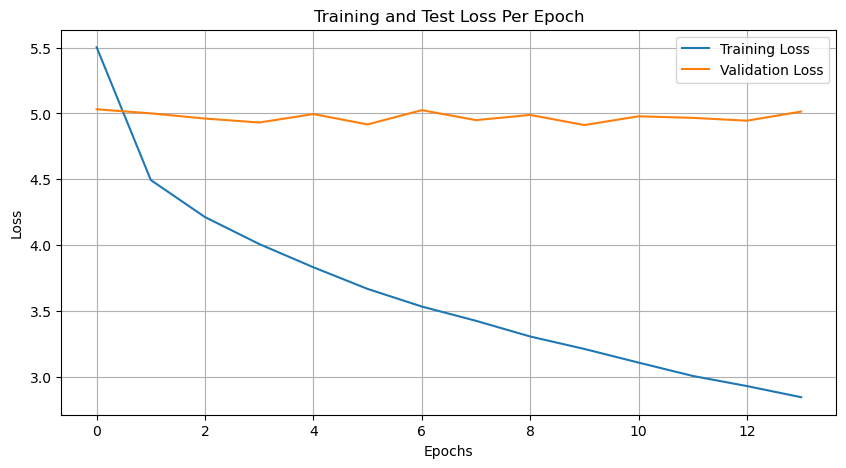

None

 14%|█▍        | 14/100 [27:46<2:48:19, 117.44s/it]

Latest Train Loss: 2.8884029388427734
Latest Test Loss: 5.974575996398926


In [ ]:
avg_train_loss = []
avg_test_loss = []
for epoch in tqdm(range(epochs)):
    train_loss = []
    test_loss = []
    nic.train()
    for image, caption in train_dataloader:
        # with torch.no_grad():
        image = image.to(device)
        caption = caption.to(device)
      # outputs = nic(image,caption)
      # loss = criterion(outputs.permute(0, 2, 1)[:,:,1:], caption[:,1:])
      # loss.backward()
      # torch.nn.utils.clip_grad_norm_(nic.parameters(),max_norm=1)
      # optimizer.step()
      # print("Loss:", loss.item())
        outputs = nic(image, caption[:,:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1)
        )
        # print("Loss:", loss.item())
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    nic.eval()
    with torch.no_grad():
        for image, caption in test_dataloader:
            image = image.to(device)
            caption = caption.to(device)
            outputs = nic(image, caption[:,:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1)
            )
            test_loss.append(loss.item())
    avg_train_loss.append(np.mean(train_loss))
    avg_test_loss.append(np.mean(test_loss))

    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_loss, label='Training Loss')
    plt.plot(avg_test_loss, label='Validation Loss')
    plt.title('Training and Test Loss Per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Clear the previous plot and display the updated plot
    clear_output(wait=True)
    tqdm.write(f'{epoch}/{epochs}')
    nic.eval()
    print(f'Sample Results:')
    with torch.no_grad():
        for act_caption, result,img in zip(caption,outputs.argmax(2),image):
            print(f'Actual: {" ".join([idx_to_word[idx.item()] for idx in act_caption])}')
            print(f'Predicted: {" ".join([idx_to_word[idx.item()] for idx in result])}')
            print(f'Image O/P: {" ".join(nic.caption_image(img.unsqueeze(0).to(device),idx_to_word))}')
            print('-'*75)
    display(plt.show())
    print("Latest Train Loss:", train_loss[-1])
    print("Latest Test Loss:", test_loss[-1])

In [ ]:
# avg_train_loss = []
# avg_test_loss = []
# for epoch in tqdm(range(epochs)):
#     train_loss = []
#     test_loss = []
#     nic.train()
#     for image, caption in train_dataloader:
#         # with torch.no_grad():
#         image = image.to(device)
#         caption = caption.to(device)
#       # outputs = nic(image,caption)
#       # loss = criterion(outputs.permute(0, 2, 1)[:,:,1:], caption[:,1:])
#       # loss.backward()
#       # torch.nn.utils.clip_grad_norm_(nic.parameters(),max_norm=1)
#       # optimizer.step()
#       # print("Loss:", loss.item())
#         outputs = nic(image, caption[:,:-1])
#         loss = criterion(
#             outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1)
#         )
#         # print("Loss:", loss.item())
#         train_loss.append(loss.item())
#         optimizer.zero_grad()
#         loss.backward(loss)
#         optimizer.step()
#     nic.eval()
#     with torch.no_grad():
#         for image, caption in test_dataloader:
#             image = image.to(device)
#             caption = caption.to(device)
#             outputs = nic(image, caption[:,:-1])
#             loss = criterion(
#                 outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1)
#             )
#             test_loss.append(loss.item())
#     avg_train_loss.append(np.mean(train_loss))
#     avg_test_loss.append(np.mean(test_loss))

#     plt.figure(figsize=(10, 5))
#     plt.plot(avg_train_loss, label='Training Loss')
#     plt.plot(avg_test_loss, label='Validation Loss')
#     plt.title('Training and Test Loss Per Epoch')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)

#     # Clear the previous plot and display the updated plot
#     clear_output(wait=True)
#     tqdm.write(f'{epoch}/{epochs}')
#     nic.eval()
#     print(f'Sample Results:')
#     with torch.no_grad():
#         for act_caption, result,img in zip(caption,outputs.argmax(2),image):
#             print(f'Actual: {" ".join([idx_to_word[idx.item()] for idx in act_caption])}')
#             print(f'Predicted: {" ".join([idx_to_word[idx.item()] for idx in result])}')
#             print(f'Image O/P: {" ".join(nic.caption_image(img.unsqueeze(0).to(device),idx_to_word))}')
#             print('-'*75)
#     display(plt.show())
#     print("Latest Train Loss:", train_loss[-1])
#     print("Latest Test Loss:", test_loss[-1])

#### Verifying Ouputs

In [ ]:
criterion(outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1))

In [ ]:
caption, outputs

In [ ]:
for act_caption, result in zip(caption,outputs.argmax(2)):
    print(f'Actual: {" ".join([idx_to_word[idx.item()] for idx in act_caption])}')
    print(f'Predicted: {" ".join([idx_to_word[idx.item()] for idx in result])}')
    print('-'*75)

In [ ]:
nic.eval()
with torch.no_grad():
    for img in image:
        output_caption = nic.caption_image(img.unsqueeze(0).to(device),idx_to_word)
        print(f'Output: {" ".join(output_caption)}')


#### Clearing VRAM

In [ ]:
def clear_vram():
    encoder.zero_grad()
    decoder.zero_grad()
    nic.zero_grad()
    torch.cuda.empty_cache()
    # del output, hidden, cell
    gc.collect()

### Save and Load Model

In [ ]:
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

filename = f"/content/drive/MyDrive/paper_replications/show_and_tell/models/nic_bestckpt_{current_time}.pth"
dataset_name = f"/content/drive/MyDrive/paper_replications/show_and_tell/models/nic_bestckpt_{current_time}.csv"
df.to_csv(dataset_name,index=None)
torch.save(nic.state_dict(),filename)
filename = f"/content/drive/MyDrive/paper_replications/show_and_tell/models/nic_bestckpt_{current_time}.pth.tar"
save_checkpoint(nic, optimizer, epoch, EMBEDDING_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, lr, avg_train_loss, avg_test_loss, filename)

In [109]:
nic.load_state_dict(torch.load('nic_2024-05-09_21-45-22.pth',map_location=device))
nic.eval()

NeuralImageCaption(
  (encoder): CNNEncoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

### Inference

In [ ]:
idx = 42
image, caption = train_dataset.__getitem__(idx)
to_pil = transforms.ToPILImage()
actual_image = to_pil(image.sigmoid())
actual_caption = []
for val in caption:
    actual_caption.append(idx_to_word[val.item()])
actual_caption = ' '.join(actual_caption)
display(actual_image)
print(f'Caption: {actual_caption}')

#### Greedy Inference

In [ ]:
nic.eval()
with torch.no_grad():
    output_caption = nic.caption_image(image.unsqueeze(0).to(device),idx_to_word)

' '.join(output_caption)

In [ ]:
to_pil = transforms.ToPILImage()
nic.eval()
with torch.no_grad():
    for images, captions in test_dataloader:
        for image,caption in zip(images,captions):
            actual_image = to_pil(image.sigmoid())
            actual_caption = []
            for val in caption:
                actual_caption.append(idx_to_word[val.item()])
            output_caption = nic.caption_image(image.unsqueeze(0).to(device),idx_to_word)
            output_caption = ' '.join(output_caption)
            actual_caption = ' '.join(actual_caption)
            print('Image:')
            display(actual_image)
            print(f'Actual Caption: {actual_caption}')
            print(f'Output Caption: {output_caption}')
            print('-'*75)
            print('\n')
        break

In [ ]:
to_pil = transforms.ToPILImage()
nic.eval()
with torch.no_grad():
    for images, captions in train_dataloader:
        for image,caption in zip(images,captions):
            actual_image = to_pil(image.sigmoid())
            actual_caption = []
            for val in caption:
                actual_caption.append(idx_to_word[val.item()])
            output_caption = nic.caption_image(image.unsqueeze(0).to(device),idx_to_word)
            output_caption = ' '.join(output_caption)
            actual_caption = ' '.join(actual_caption)
            print('Image:')
            display(actual_image)
            print(f'Actual Caption: {actual_caption}')
            print(f'Output Caption: {output_caption}')
            print('-'*75)
            print('\n')
        break

In [ ]:
# result_caption = []
# temperature = 0.3
# with torch.no_grad():
#     x = nic.encoder(image.unsqueeze(0).to(device)).unsqueeze(0)
#     states = None

#     for _ in range(nic.caption_len):
#         hiddens, states = nic.decoder.lstm(x, states)
#         output = nic.decoder.fc(hiddens.squeeze(0))
#         output = output.div(temperature).exp()  # Apply temperature scaling
#         predicted = torch.multinomial(output, 1)  # Sampling

#         # Append the predicted word to the caption
#         predicted_word_idx = predicted.item()
#         predicted = output.argmax(1)
#         result_caption.append(predicted.item())
#         x = nic.decoder.Word2VecEmbedding(predicted).unsqueeze(0)

#         if idx_to_word[predicted.item()] == "<end>":
#             break

#### Greedy search X2

In [ ]:
# image = image.unsqueeze(0).to(device)
# softmax = nn.Softmax(dim=0).to(device)
# output_caption = []
# nic.eval()
# output = nic.encoder(image)
# predictions, output, hidden, cell = nic.decoder(output,image=True)
# with torch.no_grad():
#     for i in range(max_doc_len):
#         pred_probs = softmax(predictions)
#         pred_idx = torch.argmax(pred_probs)
#         word = idx_to_word[pred_idx.item()]
#         output_caption.append(word)
#         if word=='<end>':
#             break
#         predictions, output, hidden, cell = nic.decoder(pred_idx.unsqueeze(0),hidden,cell)
# final_caption = ' '.join(output_caption)
# final_caption

In [ ]:
# captions_size = 20
# caption_indices = [np.random.randint(len(test_dataset)) for i in range(captions_size)]

In [ ]:
# image_list = torch.stack([image for i in range(captions_size)])
# caption_list = []
# for caption_index in caption_indices:
#     _, caption = test_dataset.__getitem__(caption_index)
#     caption_list.append(caption)
# # caption_list = torch.tensor(caption_list)
# caption_list = torch.stack(caption_list)
# caption_list.shape, image_list.shape
# # Consider some random k sentences.
# # Iterate for t times where in each iteration you generate new sentences from old k best.
# # After t iterations, select the best sentence from k sentences based on probability.

In [ ]:
# caption_list

In [ ]:
# T = 20
# image_list = image_list.to(device)
# nic.batch_size = captions_size
# nic.eval()
# with torch.no_grad():
#     for t in tqdm(range(T)):
#         caption_list = caption_list.to(device)
#         # 20x50x1510
#         outputs = nic(image_list,caption_list)
#         caption_list = torch.argmax(outputs,dim=2)

In [ ]:
# preds = nn.Softmax(outputs,dim=2)

In [ ]:
# outputs = torch.zeros(batch_size,max_doc_len,OUTPUT_SIZE).to(device)
# output = encoder(image)
# prediction, output, hidden, cell = decoder(output,image=True)
# for word_idx in range(1,max_doc_len):
#     prediction, output, hidden, cell = nic.decoder(output,hidden,cell,image=True)
#     outputs[:,word_idx] = prediction

In [ ]:
# output = nic.encoder(image)
# predictions, _, _, _ = nic.decoder(output,image=True)

In [ ]:
# target = torch.zeros(batch_size,max_doc_len,OUTPUT_SIZE)
# for row in range(target.shape[0]):
#     print(f'Sample {row+1}')
#     output_caption = []
#     for row2 in range(caption.shape[1]):
#         wordidx = caption[row,row2]
#         target[row,row2,caption[row,row2]] = 1
#         output_caption.append(idx_to_word[wordidx.item()])
#     output_caption = ' '.join(output_caption)
#     print(f'Output: {output_caption}')

In [ ]:
# fin_output = torch.argmax(outputs,dim=2)
# for row in range(fin_output.shape[0]):
#     print(f'Sample {row+1}')
#     output_caption = []
#     for col in range(fin_output.shape[1]):
#         wordidx = fin_output[row,col]
#         output_caption.append(idx_to_word[wordidx.item()])
#     output_caption = ' '.join(output_caption)
#     print(f'Output: {output_caption}')

### Evaluation: BLEU

In [110]:
nic.eval()
scores = []
wts =  (1, 0, 0, 0)
smoothie = SmoothingFunction().method1
with torch.no_grad():
    for images, caption in test_dataset:
        output_caption = nic.caption_image(image.unsqueeze(0).to(device),idx_to_word)
        target_caption = [[idx_to_word[caption_idx.item()] for caption_idx in caption]]
        scores.append(sentence_bleu(target_caption,output_caption,weights=wts,smoothing_function=smoothie))

print(f'BLEU-1 Score: {np.mean(scores)*100}%')

BLEU-1 Score: 21.61093268833718%


In [ ]:
nic.eval()
scores = []
wts =  (0.25, 0.25,0.25, 0.25)
smoothie = SmoothingFunction().method1
with torch.no_grad():
    for images, caption in test_dataset:
        output_caption = nic.caption_image(image.unsqueeze(0).to(device),idx_to_word)
        target_caption = [[idx_to_word[caption_idx.item()] for caption_idx in caption]]
        scores.append(sentence_bleu(target_caption,output_caption,weights=wts,smoothing_function=smoothie))

print(f'BLEU-4 Score: {np.mean(scores)*100}%')